- #### Exercicis per practicar amb regressions.

## Exercici 1

- #### Crea almenys dos models de regressió diferents per intentar predir el millor possible el preu de les vivendes (MEDV) de l'arxiu adjunt.



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, KFold, RandomizedSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor




import warnings
warnings.filterwarnings("ignore")



## 1.1 Estudi i anàlisi de la Base de dades

In [2]:
# Llegeixo el dataframe
HousingBoston = pd.read_csv('/Users/angelssastrenadal/ITAcademy_Exercicis/Sprint_6/housing_data.csv', header=None)
HousingBoston.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
#Li assigno el nom de columnes segons info al .txt
HousingBoston.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Donat que en l'exercici anterior ja hem vist que no hi ha nuls, nans o duplicats i que tenim la info del database:
- CRIM — per capita crime rate by town
- ZN — proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS — proportion of non-retail business acres per town.
- CHAS — Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX — nitric oxides concentration (parts per 10 million)
- RM — average number of rooms per dwelling
- AGE — proportion of owner-occupied units built prior to 1940
- DIS — weighted distances to five Boston employment centres
- RAD — index of accessibility to radial highways
- TAX — full-value property-tax rate per 10000 USD
- PTRATIO — pupil-teacher ratio by town
- B  — One Thousand(Bk — 0.63)² where Bk is the proportion of blacks by town
- LSTAT — Percentage lower status of the population
- MEDV — Median value of owner-occupied homes in 1000 USD
______________________________________________

- CRIM es compte amb un index entre 0,01 i 88,98 veiem que el 75% dels barris el rati de criminalitat es baixa, amb el 75% de la mostra amb menys de 3,68
- ZN Els terrenys de mes de 25000 peus cuadrats son el 11,36% de mitja
- RM La mitja d'habitacions es molt alta 6,28
- PTRATIO El nombre d'alumnes per professor es troba entre 12,6 i 22, em sembla baix
- B Em sorprén que tinguin en compte com indicador, la proporció de la població negre. 
- El valor mig de vivendes MEDV es troba entre 5000 i 50000
-**Variables categòriques:**
- El paràmetre CHAS(prop del riu Charles o no) es binari, per tant s'ha de tractar diferent a la resta:
"dummy variable (1 if tract bounds river; 0 otherwise)"
- També RAD "(index d'accés a autopistes radials)". 

Veure exercici anterior a github per referencia: [M5 T02](https://github.com/angeliufus/SkLearn_Train_Test/blob/main/TASCA%20M5%20T02.ipynb). On hem fet una neteja previa de la bdd i hem vist que RAD i CHAS son categoriques, no ni ha nulls i nans ni duplicats.
També hem vist que les variables no son normalment distribuides i que 'CRIM', 'ZN', 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT' i 'MEDV'tenien outliers.

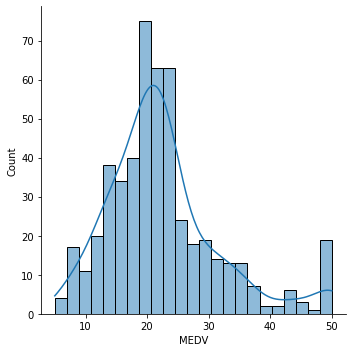

In [3]:
#Mirem de nou la distribució gràfica de MEDV:
sns.displot(data=HousingBoston, x="MEDV", kde=True)

In [4]:
#Com hem vist en l'exercici anterior la variable RAD es categorica i no està dumificada
#Per tant la dumifiquem abans de preprocessar les dades
HousingBoston_transf = pd.get_dummies(data = HousingBoston, columns= ['RAD'])
HousingBoston_transf.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,...,MEDV,RAD_1,RAD_2,RAD_3,RAD_4,RAD_5,RAD_6,RAD_7,RAD_8,RAD_24
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,296.0,15.3,...,24.0,1,0,0,0,0,0,0,0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,242.0,17.8,...,21.6,0,1,0,0,0,0,0,0,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,242.0,17.8,...,34.7,0,1,0,0,0,0,0,0,0
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,222.0,18.7,...,33.4,0,0,1,0,0,0,0,0,0
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,222.0,18.7,...,36.2,0,0,1,0,0,0,0,0,0


## 1.2 PreProcessat

In [5]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
#Preprocessem amb un Robust Scaler les dades que tenen outliers
columnsRobust = ['CRIM','ZN','RM','DIS','PTRATIO','B','LSTAT']
scaler = preprocessing.RobustScaler().fit(HousingBoston_transf[columnsRobust])
HousingBoston_transf[columnsRobust] = scaler.transform(HousingBoston_transf[columnsRobust])
HousingBoston_transf.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,...,MEDV,RAD_1,RAD_2,RAD_3,RAD_4,RAD_5,RAD_6,RAD_7,RAD_8,RAD_24
0,-0.069593,1.44,2.31,0,0.538,0.496612,65.2,0.285777,296.0,-1.339286,...,24.0,1,0,0,0,0,0,0,0,0
1,-0.063755,0.00,7.07,0,0.469,0.287940,78.9,0.569789,242.0,-0.446429,...,21.6,0,1,0,0,0,0,0,0,0
2,-0.063760,0.00,7.07,0,0.469,1.323171,61.1,0.569789,242.0,-0.446429,...,34.7,0,1,0,0,0,0,0,0,0
3,-0.062347,0.00,2.18,0,0.458,1.069783,45.8,0.924391,222.0,-0.125000,...,33.4,0,0,1,0,0,0,0,0,0
4,-0.052144,0.00,2.18,0,0.458,1.271680,54.2,0.924391,222.0,-0.125000,...,36.2,0,0,1,0,0,0,0,0,0


In [6]:
from sklearn.preprocessing import MinMaxScaler
#Preprocessem amb un MinMaxScaler les dades que NO tenen outliers
columnsminmax = ['INDUS', 'NOX', 'TAX', 'AGE']
trans = MinMaxScaler()
HousingBoston_transf[columnsminmax] = trans.fit_transform(HousingBoston_transf[columnsminmax])
HousingBoston_transf.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,...,MEDV,RAD_1,RAD_2,RAD_3,RAD_4,RAD_5,RAD_6,RAD_7,RAD_8,RAD_24
0,-0.069593,1.44,0.067815,0,0.314815,0.496612,0.641607,0.285777,0.208015,-1.339286,...,24.0,1,0,0,0,0,0,0,0,0
1,-0.063755,0.00,0.242302,0,0.172840,0.287940,0.782698,0.569789,0.104962,-0.446429,...,21.6,0,1,0,0,0,0,0,0,0
2,-0.063760,0.00,0.242302,0,0.172840,1.323171,0.599382,0.569789,0.104962,-0.446429,...,34.7,0,1,0,0,0,0,0,0,0
3,-0.062347,0.00,0.063050,0,0.150206,1.069783,0.441813,0.924391,0.066794,-0.125000,...,33.4,0,0,1,0,0,0,0,0,0
4,-0.052144,0.00,0.063050,0,0.150206,1.271680,0.528321,0.924391,0.066794,-0.125000,...,36.2,0,0,1,0,0,0,0,0,0


**REGRESSIO LINEAL**

Abans de definir el target miro la correlació de MEDV (Median value of owner-occupied homes in 1000 USD) amb la resta de variables.

Mirem la correlació i la regressió de la variable MEDV respecte les altres amb np.polyfit() aquesta funció serveix per fer una linea de regressió lineal al scatterplot de la variable x que en aquest representa cada columna respecte MEDV que serà la variable que es la linea en color en color verd. np.poly1d() crea una funció polinomica a  (una linea en aquest cas ) amb els coeficients generats per np.polyfit().
Agafo nomes les 13 primeres columnes per no agafar RAD que es un index categòric.

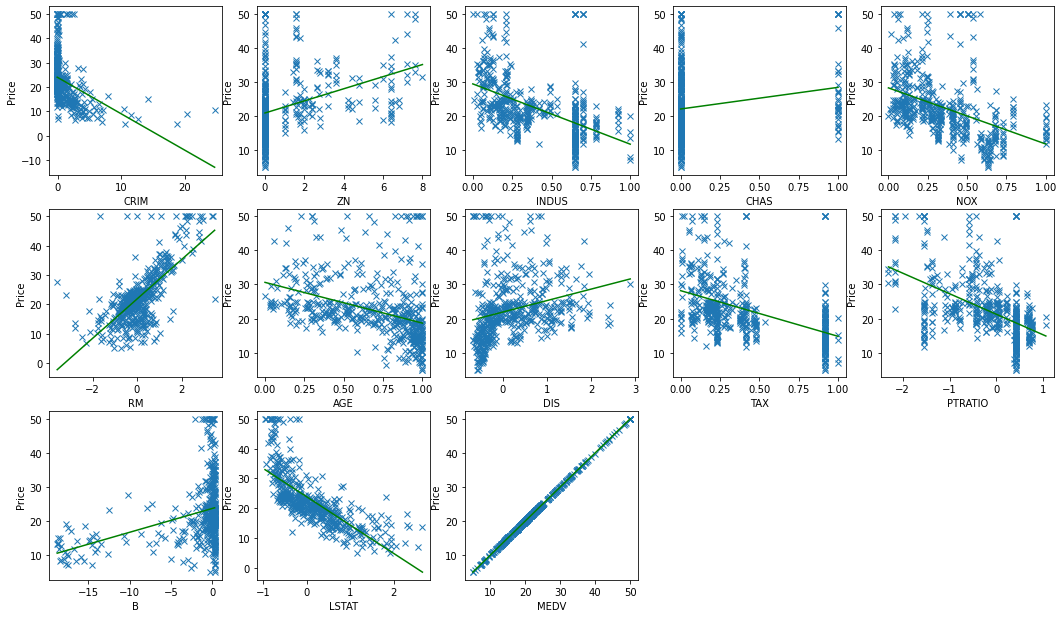

In [7]:
plt.figure(figsize=(18, 18))

for i, idx in enumerate(HousingBoston_transf.columns[0:13]):
    plt.subplot(5, 5, i+1)
    x = HousingBoston_transf[idx]
    y = HousingBoston_transf['MEDV']
    plt.plot(x, y, 'x')
    
# Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1)) (np.unique(x)), color='green')
    plt.xlabel(idx)
    plt.ylabel('Price')

En funció d'aixó veiem que RM AGE TAX i LSTAT son els que tenen més correlació linear amb la variable objectiu MEDV.


In [8]:
from sklearn.model_selection import train_test_split
# Separo la bdd entre features i target posant al eix Y el target, no considero les variables categòriques RAD i CHAS


X = HousingBoston_transf.drop(['MEDV'],axis=1)
y = HousingBoston_transf['MEDV']


Podem mirar si existeix multicolonialitat, es tracta d'un fenomen en què hi ha una correlació alta entre les variables d'un conjunt de dades, el que pot afectar negativament els resultats de les anàlisis estadístiques. Quan això passa, les variables afectades poden ser redundants, cosa que implica pèrdua de informació i modelatge més complex.

In [9]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ajustem un model lineal als nostres dades
model = sm.OLS(X, y)

# calculem el factor d'inflació de la variança per a cada variable
vif_array = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print(vif_array)

[1.81186747861482, 2.4961842211294596, 4.3704710743014585, 1.1018427797894328, 4.6729064695329745, 2.0075931394301687, 3.177556368310554, 4.143582866154159, 9.876852501300885, 2.2426831723843783, 1.3525155027083597, 2.997620158154093, 2.132194585131449, 2.2674907996877494, 2.4426754761789993, 6.603069395415358, 7.724868024960576, 2.2505855848114806, 1.9103068483867232, 2.326986227952637, 21.472622126249426]


En general, un valor de multicolinealitat superior a 5 o 10 indica una alta multicolinealitat. Veiem que la variable INDUS, NOX, AGE, TAX, RAD 4, RAD 5 i RAD 24 tenen unes multicolonialitats molt elevades, està altament correlacionada amb altres variables del conjunt de dades, el que pot afectar negativament les anàlisis estadístiques... I ho tindrem en compte per els resultats dels models predictius mes endavant.
Hem de tenir en compte:
*-"Multicollinearity affects the coefficients and p-values, but it does not influence the predictions, precision of the predictions, and the goodness-of-fit statistics. If your primary goal is to make predictions, and you don’t need to understand the role of each independent variable, you don’t need to reduce severe multicollinearity."-*
https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

## 1.3 Separem amb Train i Test 

Es recomanable aplicar train i test abans d'aplicar la regressió lineal o qualsevol altre algorisme de machine learning.

Aquesta separació serveix per evitar l'overfitting (sobreajustament) del model, ja que si utilitzem totes les dades per entrenar el model, aquest es pot ajustar excessivament a les dades d'entrenament i 
no permetrà prediccions acurades sobre les dades de prova.

Per tant, dividim les dades en dos conjunts: entrenament i prova. La idea és utilitzar el conjunt d'entrenament per ajustar el model i el conjunt de prova per avaluar la seva precisió.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
X_train.describe()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,...,LSTAT,RAD_1,RAD_2,RAD_3,RAD_4,RAD_5,RAD_6,RAD_7,RAD_8,RAD_24
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,...,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,0.961816,0.879703,0.389492,0.061881,0.354086,0.086268,0.679653,0.187904,0.431472,-0.205888,...,0.142750,0.039604,0.047030,0.079208,0.195545,0.227723,0.054455,0.042079,0.042079,0.272277
std,2.363608,1.835343,0.251833,0.241238,0.242091,0.965179,0.289352,0.691345,0.324530,0.775367,...,0.722140,0.195269,0.211965,0.270398,0.397111,0.419883,0.227196,0.201019,0.201019,0.445684
min,-0.069593,0.000000,0.010264,0.000000,0.000000,-3.587398,0.000000,-0.672824,0.000000,-2.303571,...,-0.962519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.049104,0.000000,0.171188,0.000000,0.131687,-0.436314,0.440525,-0.362527,0.179389,-0.598214,...,-0.418791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.001711,0.000000,0.338343,0.000000,0.314815,0.000000,0.768280,-0.021096,0.281489,0.017857,...,0.003498,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.012609,1.000000,0.646628,0.000000,0.539095,0.539973,0.937436,0.626253,0.914122,0.410714,...,0.574213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,24.678377,8.000000,1.000000,1.000000,1.000000,3.484417,1.000000,2.888060,1.000000,1.053571,...,2.659670,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Veiem que agafa el 80% de les dades per el train i el 20% per el test amb 404 i 102 registres:

In [11]:

y_test.describe()


count    102.000000
mean      23.461765
std        9.685500
min        6.300000
25%       17.575000
50%       20.500000
75%       27.875000
max       50.000000
Name: MEDV, dtype: float64

## 1.4 Apliquem 3 Models: Linear Regression, Support Vector Machines i Random Forest Regression

--- *Linear Regression* ---

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Apliquem el model de regressió lineal
model_LR = LinearRegression()
# Entrenem el model a les dades d'entrenament amb fit
model_LR.fit(X_train, y_train)
y_pred_linreg= model_LR.predict(X_test)

print('La precisió del Training: ',model_LR.score(X_train, y_train)*100)
print("La precisió del testing és: ", model_LR.score(X_test, y_test)*100)
print("La precisió del Model de regressió lineal és : ", r2_score(y, model_LR.predict(X))*100)

La precisió del Training:  75.26936409104052
La precisió del testing és:  72.72841038730695
La precisió del Model de regressió lineal és :  74.76959395184765


Veiem que la precisió es menor en les dades de test que en el entrenament. 


R-squared score: 0.7272841038730695
Mitja cuadratica score: 25.332368055544134


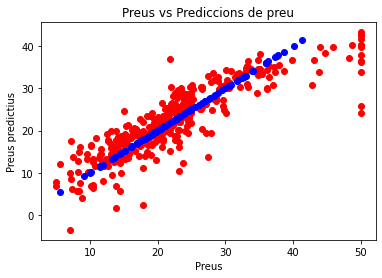

In [13]:

# Calculate the R-squared score

r2_linreg= r2_score(y_test, y_pred_linreg)
mse_linreg = mean_squared_error(y_test, y_pred_linreg)
print("R-squared score:", r2_linreg)
print("Mitja cuadratica score:", mse_linreg)

plt.scatter(y_train, model_LR.predict(X_train), c='red', label='Actual', cmap='viridis')
plt.scatter(model_LR.predict(X_test), y_pred_linreg, c='blue', label='Predicted', cmap='viridis')
#faig un scatter plot de les dades entrenades de preu en vermell i les prediccions de preu en blau
plt.xlabel("Preus")
plt.ylabel("Preus predictius")
plt.title("Preus vs Prediccions de preu")
plt.show()



-La MSE (mitja cuadràtica) indica com d'aprop està la regressió dels punts que veiem. Com mes petit és el MSE, millor serà el pronóstic.
-El R2 mesura la relació lineal entre X e Y, és la proporció de la variança en la variable dependent que es pot predir a partir de la variable independent.

--- *Support Vector Machines* ---

In [14]:
from sklearn.svm import SVR
Model_SVR = SVR()
Model_SVR.fit(X_train, y_train)
y_pred_svr = Model_SVR.predict(X_test)
print('La precisió del training és: ', Model_SVR.score(X_train, y_train)*100)
print("La precisió del testing és: ", Model_SVR.score(X_test, y_test)*100)
print("La precisió del Model de Support Vector Machines és : ", r2_score(y, Model_SVR.predict(X))*100)

La precisió del training és:  62.800463083485994
La precisió del testing és:  51.64176847835732
La precisió del Model de Support Vector Machines és :  60.421413075690765


R-squared score: 0.5164176847835732
Mitja cuadratica score: 44.91958616344468


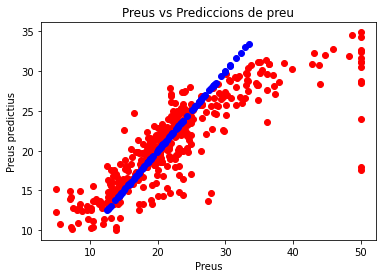

In [15]:
r2_SVR = r2_score(y_test, y_pred_svr)
mse_SVR = mean_squared_error(y_test, y_pred_svr)
print("R-squared score:", r2_SVR)
print("Mitja cuadratica score:", mse_SVR)

plt.scatter(y_train, Model_SVR.predict(X_train), c='red', label='Actual', cmap='viridis')
plt.scatter(Model_SVR.predict(X_test), y_pred_svr, c='blue', label='Predicted', cmap='viridis')
plt.xlabel("Preus")
plt.ylabel("Preus predictius")
plt.title("Preus vs Prediccions de preu")
plt.show()

- Veiem que les prediccions aqui no s'acosten tant a la mostra.

In [16]:
model_RFR = RandomForestRegressor(random_state = 3)
model_RFR.fit(X_train, y_train) #entrenem les dades d'entrenament amb X_train i y_train 
y_pred_RFR = model_RFR.predict(X_test) #fem prediccions sobre les dades de proves X_test
print('La precisió del training és: ', model_RFR.score(X_train, y_train)*100)
print("La precisió del testing és: ", model_RFR.score(X_test, y_test)*100)
print("La precisió del Model de Random Forest és : ", r2_score(y, model_RFR.predict(X))*100)


La precisió del training és:  97.92150429665716
La precisió del testing és:  81.0143778116478
La precisió del Model de Random Forest és :  94.1767783235122


R-squared score: 0.8101437781164781
Mitja cuadratica score: 17.63559718627452


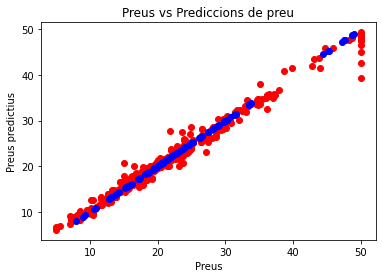

In [17]:
from sklearn.metrics import r2_score
r2_RFR = r2_score(y_test, y_pred_RFR)
mse_RFR = mean_squared_error(y_test, y_pred_RFR)
print("R-squared score:", r2_RFR)
print("Mitja cuadratica score:", mse_RFR)

plt.scatter(y_train, model_RFR.predict(X_train), c='red', label='Actual', cmap='viridis')
plt.scatter(model_RFR.predict(X_test), y_pred_RFR, c='blue', label='Predicted', cmap='viridis')
plt.xlabel("Preus")
plt.ylabel("Preus predictius")
plt.title("Preus vs Prediccions de preu")
plt.show()

In [18]:
#comparo les prediccions 
y_pred_linreg = model_LR.predict(X_test).ravel()
y_pred_svr = Model_SVR.predict(X_test).ravel()
y_pred_RFR = model_RFR.predict(X_test).ravel()

prediccion = pd.DataFrame({
    'PREDICCIÓ LIN REG': y_pred_linreg,
    'PREDICCIÓ RandomForest': y_pred_RFR,
    'PREDICCIÓ Support Vector Machine': y_pred_svr
})

prediccion.head(5)

,PREDICCIÓ LIN REG,PREDICCIÓ RandomForest,PREDICCIÓ Support Vector Machine
0,11.921270,18.550,17.243369
1,24.881995,24.587,25.411792
2,17.238390,19.516,18.597100
3,17.647421,18.524,15.820035
4,37.415302,47.291,31.626584


## - Exercici 2
- #### Compara’ls en base al MSE i al R2.

In [19]:
metrics = pd.DataFrame( data = [['Linear Regression', r2_linreg, mse_linreg],['Support Vector MACHINES', r2_SVR, mse_SVR],
                                  [' Random Forest Regressor', r2_RFR, mse_RFR]],
                                  columns = ['Model', 'R2', 'MSE'])
metrics.head()

,Model,R2,MSE
0,Linear Regression,0.727284,25.332368
1,Support Vector MACHINES,0.516418,44.919586
2,Random Forest Regressor,0.810144,17.635597


Com menor es el MSE, millor serà el pronòstic.
El R2 es una mida de la relació lineal entre X e Y, s'interpreta com la proporció de la variança en la variable depenent que es pot predir a partir de la variable independent.

-*Aqui veiem que el model Random Forest es molt millor que els altres models, ja que les mostres s'acosten molt mes a les prediccions.Tantmateix la MSE (mitja cuadràtica) es molt baixa e indica que està molt aprop de la regressió dels punts que veiem. 



Overfitting happens when a model performs well on the training data but poorly on the testing or new data. 
To check for overfitting in your trained model, you can use the following approaches:

Regularization is a technique used to prevent overfitting by adding a penalty term to the loss function.
A popular method is L1 or L2 regularization which adds a penalty term that is proportional to the magnitude
of the model weights. This technique forces the model to select only the most important features and reduces 
the magnitude of the weights, reducing the complexity of the model.

## - Exercici 3
- #### Entrena’ls utilitzant els diferents paràmetres que admeten per intentar millorar-ne la predicció.

### Mirem els parametres de cada model:

### Definim parametres i modifiquem els possibles valors ###

GridSearchCV es una tecnica per trobar els valors dels hyperparametres optim de un set de parametres
en un grid. Es esencialment una tecnica de cross-validation . Has de posar el model i els parametres.
Despres de extreure els millors parametres, es fan les prediccions.

In [20]:
model_LR.get_params() #LInear Regression parameters

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [21]:
from sklearn.model_selection import GridSearchCV #Tècnica usada per ajustar hiperparàmetres dels models d'aprenentatge automàtic.

#### "Grid Search és adequat per a la definició dels hiperparàmetres dels models SVM i altres models de classificació, però no té sentit per a models de regressió lineal. Això és perquè la regressió lineal no té hiperparàmetres per ajustar. El model de regressió lineal ajusta els coeficients del model als valors de les variables d'entrada per tal de minimizar l'error quadràtic mitjà." 


Per tant nomes miraré en aquest cas si els parametres sugerits per GRIDSEARCH, coincideixen amb els parametres utilitzats per el nostre model de **LINEAR REGRESSION**

In [22]:
#definim parametres per LINEAR REGRESSION
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

In [23]:
grid = GridSearchCV(LinearRegression(), param_grid, cv=5)
grid.fit(X, y)
print(grid.best_params_)

{'copy_X': True, 'fit_intercept': True, 'positive': False}


Com veiem coincideixen els mateixos valors que ja hem utilitzat amb el nostre model, per tant no te sentit intentar optimitzar-los.

Per tant, es millor definir i ajustar parametres per **RANDOM FOREST** ja que també és el que ens ha donat millors resultats:

In [24]:
model_RFR.get_params() # miro els parameters utilitzats amb el model de Random Forest que he aplicat anteriorment.


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 3,
 'verbose': 0,
 'warm_start': False}

-El Random grid search l'hem de fer sobre totes les dades i sempre  amb la mateixa seed!!

In [25]:

#definim nous parametres per RANDOM FOREST

param_gridRF = {
    'n_estimators': [50, 100, 150],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [26]:
 #declaro model de nou amb els nous parametres
grid_RF = GridSearchCV(RandomForestRegressor(random_state = 3), param_grid=param_gridRF, cv = 5)


In [27]:
grid_RF.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=3),
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]})

In [28]:
print(grid_RF.best_params_) #mirem quins son els millors parametres 


{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


Repetim el model indicant els parametres:

In [29]:
# Entrenem el model a les dades d'entrenament amb fit i els millors parametres
modelRFR_bp = RandomForestRegressor(max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=50 )
y_pred_RFRbp = modelRFR_bp.predict(X_test)
scoresRFRbp = cross_val_score(
            estimator=modelRFR_bp, 
            X=X_train, 
            y=y_train 
)



print('La precisió del Training: ',modelRFR_bp.score(X_train, y_train)*100)
print("La precisió del testing és: ", modelRFR_bp.score(X_test, y_test)*100)
print("La precisió del Model Random Forest Regressor és : ", r2_score(y, modelRFR_bp.predict(X))*100)


La precisió del Training:  97.5504713037361
La precisió del testing és:  82.75198602793078
La precisió del Model Random Forest Regressor és :  94.27441072724666


-Veiem que la precissió del testing i el model en sí, han millorat una mica: La precisió del training era:  97.92150429665716
La precisió del testing era:  81.0143778116478
La precisió del Model de Random Forest era :  94.1767783235122



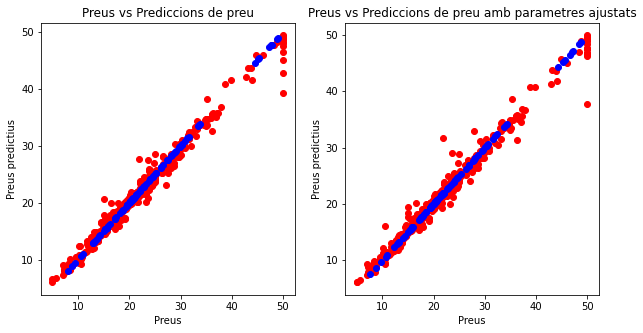

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Gràfic 1
ax1.scatter(y_train, model_RFR.predict(X_train), c='red', label='Actual', cmap='viridis')
ax1.scatter(model_RFR.predict(X_test), y_pred_RFR, c='blue', label='Predicted', cmap='viridis')
ax1.set_xlabel("Preus")
ax1.set_ylabel("Preus predictius")
ax1.set_title("Preus vs Prediccions de preu")

# Gràfic 2
ax2.scatter(y_train, modelRFR_bp.predict(X_train), c='red', label='Actual', cmap='viridis')
ax2.scatter(modelRFR_bp.predict(X_test), y_pred_RFRbp, c='blue', label='Predicted', cmap='viridis')
ax2.set_xlabel("Preus")
ax2.set_ylabel("Preus predictius")
ax2.set_title("Preus vs Prediccions de preu amb parametres ajustats")

plt.show()

Veiem que la precisió del testing i del model en si,  han millorat lleugerament.

També mirem si ajustant parametres per **SUPPORT VECTOR MACHINES** milloren els resultats:

In [31]:

Model_SVR.get_params() # parameters del model Support Vector Machines anterior.

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [34]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
param_gridSVM = {
    'kernel' : ('linear', 'rbf'),
    'C' : [1,5,10],
    'degree' : [3,8],
    'coef0' : [0.01,10,0.5],
}


In [35]:
 #declaro model de nou 

SVMgrid = GridSearchCV(SVR(gamma='auto'), param_gridSVM, cv=5)

In [36]:
SVMgrid.fit(X, y) 


GridSearchCV(cv=5, estimator=SVR(gamma='auto'),
             param_grid={'C': [1, 5, 10], 'coef0': [0.01, 10, 0.5],
                         'degree': [3, 8], 'kernel': ('linear', 'rbf')})

In [38]:
print(SVMgrid.best_score_)

0.48626323987846476


In [39]:
print(SVMgrid.best_params_)

{'C': 10, 'coef0': 0.01, 'degree': 3, 'kernel': 'rbf'}


In [40]:
# Entrenem el model a les dades d'entrenament amb fit i els millors parametres
ModelSVR_bp = SVR(kernel='rbf', gamma='auto',degree= 3,coef0= 0.01,C= 10).fit(X_train,y_train)

y_pred_SVRbp = ModelSVR_bp.predict(X_test)
scoresSVRbp = cross_val_score(
            estimator=ModelSVR_bp, 
            X=X_train, 
            y=y_train, 
            cv=5,
)

print(scoresSVRbp) #miro la puntuació en 5 seccions diferents
print('La precisió del Training: ',ModelSVR_bp.score(X_train, y_train)*100)
print("La precisió del testing és: ", ModelSVR_bp.score(X_test, y_test)*100)
print("La precisió del Model Support Vector Machines és : ", r2_score(y, ModelSVR_bp.predict(X))*100)

[0.81357912 0.75656911 0.844858   0.83306356 0.66260689]
La precisió del Training:  85.94722858320878
La precisió del testing és:  76.31837793526628
La precisió del Model Support Vector Machines és :  83.8477669937365


Veiem també que amb SVM també millora molt la precisió i per tant les prediccions. Veiem-ho gràficament:
    

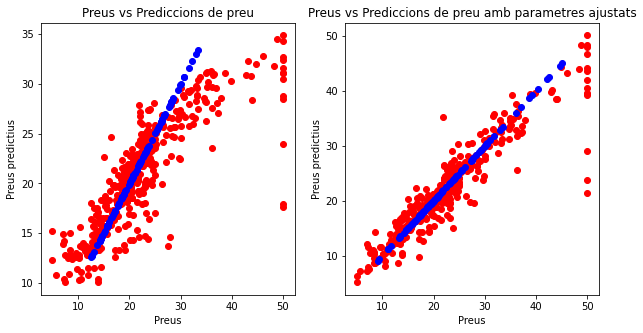

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Gràfic 1
ax1.scatter(y_train, Model_SVR.predict(X_train), c='red', label='Actual', cmap='viridis')
ax1.scatter(Model_SVR.predict(X_test), y_pred_svr, c='blue', label='Predicted', cmap='viridis')
ax1.set_xlabel("Preus")
ax1.set_ylabel("Preus predictius")
ax1.set_title("Preus vs Prediccions de preu")


# Gràfic 2
ax2.scatter(y_train, ModelSVR_bp.predict(X_train), c='red', label='Actual', cmap='viridis')
ax2.scatter(ModelSVR_bp.predict(X_test), y_pred_SVRbp, c='blue', label='Predicted', cmap='viridis')
ax2.set_xlabel("Preus")
ax2.set_ylabel("Preus predictius")
ax2.set_title("Preus vs Prediccions de preu amb parametres ajustats")

plt.show()

Veiem clarament com ara les prediccions s'acosten molt mes a la mostra.

## Exercici 4

- #### Compara el seu rendiment emprant l’aproximació train/test o emprant totes les dades (validació interna).

In [45]:
# Rendiment Linear Regression
scoresCVLR = cross_val_score(LinearRegression(), X, y,cv=5,scoring ='r2')

max(scoresCVLR)



0.7427811836275239

In [46]:
# Rendiment Random Forest Regression

scoresCVRFR = cross_val_score(RandomForestRegressor(random_state = 3),X,y,cv=5,scoring= 'r2' )
max(scoresCVRFR)


0.8509168400063607

In [47]:
# Rendiment Support Vector Machines
scoresCVSVR = cross_val_score(SVR(), X,y, cv=5,scoring= 'r2')
max(scoresCVSVR)


0.6625847351640337

In [50]:
metrics = pd.DataFrame( data = [['Linear Regression', r2_linreg, max(scoresCVLR)],['Support Vector MACHINES', r2_SVR, max(scoresCVSVR)],
                                  [' Random Forest Regressor', r2_RFR, max(scoresCVRFR)]],
                                  columns = ['Model', 'R2 train/test', 'CrossVal'])
metrics.head()

,Model,R2 train/test,CrossVal
0,Linear Regression,0.727284,0.742781
1,Support Vector MACHINES,0.516418,0.662585
2,Random Forest Regressor,0.810144,0.850917


En tots els casos el rendiment sempre es millor emprant el Cross Validation i Random Forest segueix donant la millor predicció.


## Exercici 5

- #### No facis servir la variable del nombre d'habitacions (RM) a l’hora de fer prediccions.

In [53]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Separo la bdd entre features i target posant al eix Y el target y treient la variable RM
X = HousingBoston_transf.drop(['MEDV'],axis=1)
y = HousingBoston_transf['MEDV']
features = X.drop(['RM'],axis=1)
target = y


In [56]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=45)

Miro la diferencia en les prediccions sense aquesta variable en el model de Random Forest ja que és el que ha donat millors resultats:

In [57]:
modelRF = RandomForestRegressor(max_depth=None, max_features='auto', min_samples_leaf=1,min_samples_split=2, n_estimators=50 )


modelRF.fit(features_train, target_train)
y_pred_RF = modelRF.predict(features_test)
print('La precisió del training és: ', modelRF.score(features_train, target_train)*100)
print("La precisió del testing és: ", modelRF.score(features_test, target_test)*100)
print("La precisió del Model de Random Forest és : ", r2_score(target, modelRF.predict(features))*100)


La precisió del training és:  97.02842077506332
La precisió del testing és:  84.3545644243051
La precisió del Model de Random Forest és :  93.76062047959604


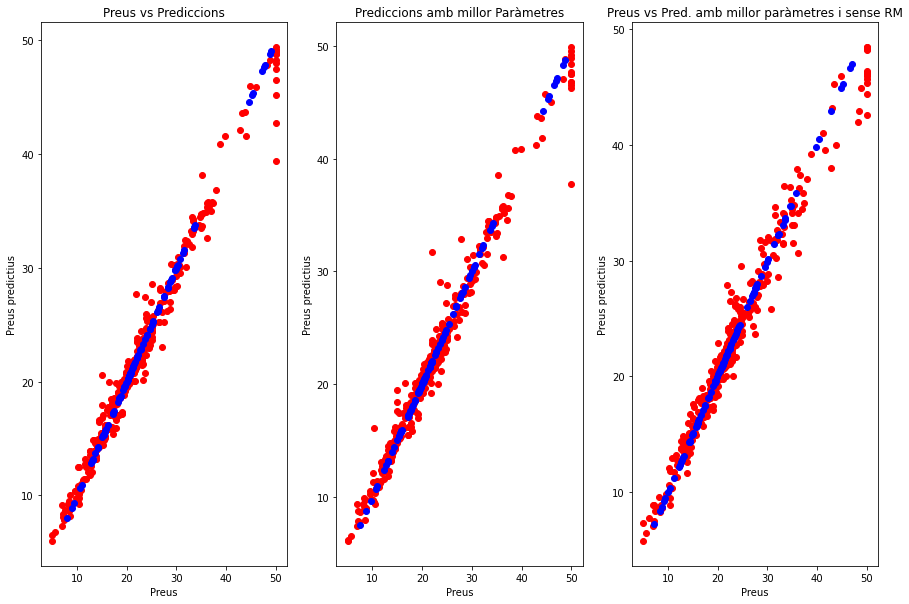

In [61]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

# Gràfic 1
ax1.scatter(y_train, model_RFR.predict(X_train), c='red', label='Actual', cmap='viridis')
ax1.scatter(model_RFR.predict(X_test), y_pred_RFR, c='blue', label='Predicted', cmap='viridis')
ax1.set_xlabel("Preus")
ax1.set_ylabel("Preus predictius")
ax1.set_title("Preus vs Prediccions")

# Gràfic 2
ax2.scatter(y_train, modelRFR_bp.predict(X_train), c='red', label='Actual', cmap='viridis')
ax2.scatter(modelRFR_bp.predict(X_test), y_pred_RFRbp, c='blue', label='Predicted', cmap='viridis')
ax2.set_xlabel("Preus")
ax2.set_ylabel("Preus predictius")
ax2.set_title("Prediccions amb millor Paràmetres")

# Gràfic 3
ax3.scatter(target_train, modelRF.predict(features_train), c='red', label='Actual', cmap='viridis')
ax3.scatter(modelRF.predict(features_test), y_pred_RF, c='blue', label='Predicted', cmap='viridis')
ax3.set_xlabel("Preus")
ax3.set_ylabel("Preus predictius")
ax3.set_title("Preus vs Pred. amb millor paràmetres i sense RM")
plt.show()


Podem veure que hem anat donant una millor predicció,millorant els paràmetres i despres ignorant la variable RM, ja estava molt correlacionada amb el target MEDV.